# Анализ программы лояльности магазина строительных материалов "Строили, строили и наконец построили"

Имеем данные о покупках в магазине строительных материалов "Строили, строили и, наконец, построили". Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности, в которую включены скидки, специальные предложения, подарки.

**Цель исследования**: анализ программы лояльности магазина, чтобы понять, приносит ли программа дополнительный доход, стимулирует ли она клиентов покупать больше товаров в магазинах.

## План работы

* Загрузка, получение общей информации и предобработка данных
* Добавление необходимых столбцов и исследовательский анализ данных
* Анализ программы лояльности
    * подсчет средних значений покупки, глубины чека и частоты покупок для тех, кто участвует в программе, и тех, кто не участвует по всем магазинам,
    * подсчет средних значений покупки, глубины чека и частоты покупок для тех, кто участвует в программе, и тех, кто не участвует только для Shop0,
    * определение чеков только с одним товаром в чеке,
    * определение клиентов только с одной покупкой за все время,
    * кластеризация клиентов.
* Проверка статистических гипотез
    * гипотеза о различии средних значений покупки, глубины чека и частоты покупок между теми, кто участвует в программе лояльности, и теми, кто не участвует для всех магазинов,
    * гипотеза о различии средних значений покупки, глубины чека и частоты покупок между теми, кто участвует в программе лояльности, и теми, кто не участвует для магазина Shop0.
* Общий вывод

## Материалы

[Презентация](https://disk.yandex.ru/d/Zjh1bTGb9ERPog)  
[Дашборд](https://public.tableau.com/app/profile/julia8036/viz/dash_retail_Grishina/Dashboard1?publish=yes)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Предобработка данных

In [2]:
# чтение файлов с данными

retail = pd.read_csv('retail_dataset.csv')
display(retail.head(10))          

product = pd.read_csv('product_codes.csv')
display(product.head(10))

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
9,539501,22372,0,2016-12-20 11:08:00,22764.0,Shop 0,1.0


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
5,22752,7.65
6,21730,4.25
7,22633,1.85
8,22632,1.85
9,84879,1.69


In [3]:
# изменение названий столбцов

retail = retail.rename(
    columns={
        'purchaseid': 'purchase_id',
        'item_ID': 'product_id',
        'Quantity': 'quantity',
        'purchasedate': 'purchase_date',
        'CustomerID': 'customer_id',
        'ShopID': 'shop_id',
    }
)

product = product.rename(
    columns={
        'productID': 'product_id',
        'price_per_one': 'product_price'
    }
)

In [4]:
# получение общей информации

print('Общая информация о датасете retail\n')
retail.info()

print('\nОбщая информация о датасете product\n')
product.info()

Общая информация о датасете retail

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_id      105335 non-null  object 
 1   product_id       105335 non-null  object 
 2   quantity         105335 non-null  int64  
 3   purchase_date    105335 non-null  object 
 4   customer_id      69125 non-null   float64
 5   shop_id          105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB

Общая информация о датасете product

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     9969 non-null   object 
 1   product_price  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9

In [5]:
# изменение типов данных

retail['customer_id'] = retail['customer_id'].astype('Int64')
retail['loyalty_program'] = retail['loyalty_program'].astype('Int64')
retail['purchase_date'] = retail['purchase_date'].astype('datetime64')

In [6]:
# доля пропущенных значений в %%

round(retail['customer_id'].isna().sum() / retail['customer_id'].count() * 100, 1)

52.4

В датасете retail в столбце `customer_id` достаточно много пропущенных значений, 52.4%. Нет точной информации об этих покупателях. Вопрос в том, могут ли клиенты магазина приобрести что-либо без персональной карты, если да, то, возможно, это как раз такие клиенты. Возможно, это те, кто совершает покупку в магазинах сети в первый раз, а персональную карту выдают после первой покупки.  
Так как у нас нет информации об этих покупателях, то заменим пропуски на одно значение.

In [7]:
# замена пропущенных значений

retail['customer_id'] = retail['customer_id'].fillna(0)

In [8]:
retail.query('purchase_id == "536409"').sort_values(by='product_id')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
18180,536409,16238,27,2016-12-01 11:45:00,23587,Shop 0,1
55567,536409,20668,23,2016-12-01 11:45:00,23587,Shop 0,1
54535,536409,20669,0,2016-12-01 11:45:00,23587,Shop 0,1
28700,536409,20713,0,2016-12-01 11:45:00,23587,Shop 0,1
16483,536409,20717,0,2016-12-01 11:45:00,23587,Shop 0,1
103733,536409,20723,0,2016-12-01 11:45:00,23587,Shop 0,1
87095,536409,20966,1,2016-12-01 11:45:00,23587,Shop 0,1
104483,536409,21065,0,2016-12-01 11:45:00,23587,Shop 0,1
492,536409,21116,0,2016-12-01 11:45:00,23587,Shop 0,1
65218,536409,21326,11,2016-12-01 11:45:00,23587,Shop 0,1


In [9]:
# проверка дубликатов

print('Количество строк-дубликатов в датасете retail:', retail.duplicated().sum())
print('Количество строк-дубликатов в датасете product:', product.duplicated().sum())

pd.set_option('display.max_rows', None)

print('\nСтроки-дубликаты в датасете retail')
display(
    retail[retail.duplicated()]
    .sort_values(by=['purchase_id', 'product_id'])
    .head(20)
)

print(
    '\nКоличество строк-дубликаты в датасете retail с ненулевым количеством купленного товара:',
    retail[retail.duplicated()]
    .query('quantity !=0')
    .sort_values(by=['purchase_id', 'product_id'])['purchase_id']
    .count()
)

print(
    'Количество строк-дубликаты в датасете retail в магазине "Shop0":',
    retail[retail.duplicated()]
    .query('shop_id == "Shop 0"')
    .sort_values(by=['purchase_id', 'product_id'])['purchase_id']
    .count()
)

Количество строк-дубликатов в датасете retail: 1033
Количество строк-дубликатов в датасете product: 0

Строки-дубликаты в датасете retail


,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
56087,536409,21866,0,2016-12-01 11:45:00,23587,Shop 0,1
54076,536409,22111,0,2016-12-01 11:45:00,23587,Shop 0,1
60212,536409,22866,0,2016-12-01 11:45:00,23587,Shop 0,1
40618,536409,22900,0,2016-12-01 11:45:00,23587,Shop 0,1
70869,536412,21448,1,2016-12-01 11:49:00,23599,Shop 0,1
86938,536412,21448,0,2016-12-01 11:49:00,23599,Shop 0,1
104964,536412,21448,1,2016-12-01 11:49:00,23599,Shop 0,1
19604,536412,21706,0,2016-12-01 11:49:00,23599,Shop 0,1
50025,536412,21708,0,2016-12-01 11:49:00,23599,Shop 0,1
77430,536412,22141,0,2016-12-01 11:49:00,23599,Shop 0,1



Количество строк-дубликаты в датасете retail с ненулевым количеством купленного товара: 340
Количество строк-дубликаты в датасете retail в магазине "Shop0": 1023


В датасете `retail` 1033 строк-дубликатов, что составляет меньше 1%. Большинство дубликатов - это товары с нулевым количеством, возможно, подарки. Строк-дубликатов с ненулевым количеством купленного товара всего 340. И почти все дубликаты приходятся на магазин "Shop 0".   
В целом, в ретейле, особенно в интернет-магазинах, задвоенные заказы являются нормой (в оффлайн магазинах задвоенные чеки все же реже встречаются, но такое тоже может быть из-за ошибки/сбоя кассового аппарата), и обычно в системе один их дубликатов помечают на удаление. Поэтому из наших данных можно такие строки удалить. Тем не менее было бы хорошо разобраться в причинах того, что в магазине образуются дубликаты.

In [10]:
# удаление дубликатов

retail = retail.drop_duplicates().reset_index(drop=True)

In [11]:
# проверка на неявные дубликаты

np.set_printoptions(threshold=9999)
print('Неявные дубликаты в столбце "shop_id"\n', retail.sort_values(by='shop_id')['shop_id'].unique())
print('Неявные дубликаты в столбце "product_id"\n', product.sort_values(by='product_id')['product_id'].unique())

Неявные дубликаты в столбце "shop_id"
 ['Shop 0' 'Shop 1' 'Shop 10' 'Shop 11' 'Shop 12' 'Shop 13' 'Shop 14'
 'Shop 15' 'Shop 16' 'Shop 17' 'Shop 18' 'Shop 19' 'Shop 2' 'Shop 20'
 'Shop 21' 'Shop 22' 'Shop 23' 'Shop 24' 'Shop 25' 'Shop 26' 'Shop 27'
 'Shop 28' 'Shop 29' 'Shop 3' 'Shop 30' 'Shop 4' 'Shop 5' 'Shop 6'
 'Shop 7' 'Shop 8' 'Shop 9']
Неявные дубликаты в столбце "product_id"
 ['10002' '10080' '10120' '10123C' '10124A' '10124G' '10125' '10133'
 '10135' '11001' '15034' '15036' '15039' '15044A' '15044B' '15044C'
 '15044D' '15056BL' '15056N' '15056P' '15056bl' '15056n' '15056p' '15058A'
 '15058B' '15058C' '15060B' '16008' '16010' '16011' '16012' '16014'
 '16015' '16016' '16033' '16045' '16046' '16048' '16052' '16054' '16156L'
 '16156S' '16161M' '16161P' '16161U' '16162L' '16168M' '16169K' '16169M'
 '16169N' '16169P' '16202E' '16206B' '16207A' '16207B' '16216' '16218'
 '16219' '16225' '16235' '16236' '16237' '16238' '16258A' '17001' '17003'
 '17007B' '17011A' '17011F' '17012A' '1701

In [12]:
# проверка некоторых кодов на аномалии

print(product.query('product_id == "47518F"'))
print(product.query('product_id == "47518f"'))
print(product.query('product_id == "AMAZONFEE"'))
print(product.query('product_id == "BANK CHARGES"'))
display(retail.query('product_id == "AMAZONFEE"'))
display(retail.query('product_id == "BANK CHARGES"'))

     product_id  product_price
6289     47518F           0.42
     product_id  product_price
5711     47518f           4.21
8324     47518f           4.13
     product_id  product_price
3891  AMAZONFEE           1.00
3931  AMAZONFEE       13541.33
4089  AMAZONFEE       13474.79
4094  AMAZONFEE        5519.25
4095  AMAZONFEE        6706.71
6133  AMAZONFEE       16888.02
6134  AMAZONFEE       16453.71
9732  AMAZONFEE        5575.28
9733  AMAZONFEE        5258.77
        product_id  product_price
2199  BANK CHARGES          15.00
3884  BANK CHARGES          95.38
5041  BANK CHARGES         966.92
8168  BANK CHARGES        1050.15
9477  BANK CHARGES         566.37
9702  BANK CHARGES         134.76
9703  BANK CHARGES         149.16
9731  BANK CHARGES         109.84


,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
1181,C537652,AMAZONFEE,-2,2016-12-07 15:51:00,0,Shop 0,0
2637,C544589,AMAZONFEE,-2,2017-02-21 15:11:00,0,Shop 0,0
8115,C540117,AMAZONFEE,-2,2017-01-05 09:55:00,0,Shop 0,0
12541,537632,AMAZONFEE,0,2016-12-07 15:08:00,0,Shop 0,0
24509,C537630,AMAZONFEE,-2,2016-12-07 15:04:00,0,Shop 0,0
34689,C537651,AMAZONFEE,-2,2016-12-07 15:49:00,0,Shop 0,0
35780,C537644,AMAZONFEE,-2,2016-12-07 15:34:00,0,Shop 0,0
58623,C540118,AMAZONFEE,-2,2017-01-05 09:57:00,0,Shop 0,0
59547,C537647,AMAZONFEE,-2,2016-12-07 15:41:00,0,Shop 0,0
62700,C544587,AMAZONFEE,-2,2017-02-21 15:07:00,0,Shop 0,0


,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
1514,C544575,BANK CHARGES,-2,2017-02-21 13:58:00,0,Shop 0,0
5032,C538680,BANK CHARGES,-2,2016-12-13 17:10:00,0,Shop 0,0
10767,541505,BANK CHARGES,0,2017-01-18 15:58:00,21618,Shop 0,0
49620,C544049,BANK CHARGES,-2,2017-02-15 12:39:00,0,Shop 0,0
54927,C537572,BANK CHARGES,-2,2016-12-07 12:00:00,0,Shop 0,0
75330,C541653,BANK CHARGES,-2,2017-01-20 11:50:00,0,Shop 0,0
80921,536779,BANK CHARGES,0,2016-12-02 15:08:00,21502,Shop 0,0
86859,C544584,BANK CHARGES,-2,2017-02-21 14:52:00,0,Shop 0,0
103668,C544576,BANK CHARGES,-2,2017-02-21 14:01:00,0,Shop 0,0


In [13]:
# просмотр непонятных кодов

list = ["C2", "D", "DCGS0003", "DCGS0055", "DCGS0057", "DCGS0069", "DCGS0070",
 "DCGS0072", "DCGS0074", "DCGS0076", "DCGSSBOY", "DCGSSGIRL", "DOT", "M", "POST",
 "S", "gift_0001_20", "gift_0001_30", "gift_0001_40", "gift_0001_50", "m"]

pd.set_option('display.max_rows', None)
retail.sort_values(by='product_id').query('product_id == @list').head(1000)

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
3307,540547,C2,0,2017-01-09 16:07:00,20590,Shop 6,0
27264,544210,C2,0,2017-02-17 11:01:00,20590,Shop 6,0
16468,536540,C2,0,2016-12-01 14:05:00,20590,Shop 6,0
37401,539337,C2,0,2016-12-17 10:46:00,0,Shop 6,0
45197,544934,C2,0,2017-02-25 09:01:00,19024,Shop 0,0
9207,C540164,C2,-2,2017-01-05 12:02:00,20590,Shop 6,0
71462,539473,C2,0,2016-12-19 14:24:00,20590,Shop 6,0
93543,542278,C2,0,2017-01-27 10:43:00,20590,Shop 6,0
47201,544390,C2,0,2017-02-18 11:36:00,20590,Shop 6,0
34903,541979,C2,0,2017-01-24 14:54:00,20590,Shop 6,0


В датасете `product` есть неявные дубли кодов продукта, где отличие только в регистре буквы кода. Скорее всего, из новых приходов товар заводили в систему с новой ценой, не проверив, что такой товар уже есть, либо, что также возможно, изначально от поставщика коды пришли в таком виде, а в систему их загрузили массово. Но на некоторые из этих дубликатов цена в датасете сильно разнится. Поэтому считаю нужным оставить эти коды как есть и не приводить их к единому формату.  
Касательно таких кодов, как "AMAZONFEE", "BANK CHARGES", то у них слишком большой разброс цен, и, судя по названию, эти коды не имеют отношения к покупке и являются комиссией банка или маркетплейса, поэтому уберем строки с этими кодами из датасета `retail`.  
Касательно остальных не совсем понятных кодов (например, "DOT", "POST", "S" и другие подобные), то поиск Google показал, что эти коды имеют отношение к логистике или к финансам, но т.к. невозможно наверняка утверждать, что в наших данных это именно так, то оставим их как есть. Если будет дополнительная информация по наименованиям кодов, то тогда уже можно будет предпринять более четкие шаги по отношению к кодам товаров.

In [14]:
# проверка столбца "quantity" на предмет выбросов

retail.query('quantity < -1000 | quantity > 1000')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
3229,539101,22693,2399,2016-12-16 10:35:00,21708,Shop 0,0
4046,543549,21986,1295,2017-02-10 09:29:00,23619,Shop 0,1
5231,537659,22189,1007,2016-12-07 16:43:00,23781,Shop 0,1
6263,543258,84611B,1286,2017-02-04 16:06:00,0,Shop 0,0
8987,540689,22469,1355,2017-01-11 08:43:00,23129,Shop 0,1
10683,543257,84611B,-1431,2017-02-04 16:06:00,0,Shop 0,0
12710,536830,84077,2879,2016-12-02 17:38:00,22433,Shop 0,1
17365,543057,84077,2591,2017-02-03 10:50:00,22012,Shop 0,1
17590,536830,21915,1399,2016-12-02 17:38:00,22433,Shop 0,1
18772,537899,22328,1487,2016-12-09 10:44:00,18434,Shop 14,0


Есть один заказ с гигантским количеством, который попал в возврат. Не очень понятно, что это. Возможно, делался пробный заказ для проверки работоспособности магазина. Т.к. он на общую сумму не влияет, то удалим это выброс из датасета. Но, в целом, нужно посмотреть, что это за товар. 

In [15]:
# новый датасет с учетом удаления некоторых строк

retail_new = pd.DataFrame(
    retail
    .query('product_id != "AMAZONFEE" & product_id != "BANK CHARGES" & -10000 < quantity < 10000'
          )
)

In [16]:
# группировка датасета product по цене товара

product_grouped = round(
    product
    .groupby('product_id', as_index=False)
    .agg({'product_price':'median'})
    , 2
)
product_grouped.columns=['product_id', 'product_price']

В датасете `product` у нас есть вилка цен почти на каждый код, при этом разброс цен в пределах кода достаточно большой - цены могут отличаться в 2 раза. Т.к нет понимания, почему цены отличаются (изменилась розничная цена или было промо), в какой момент изменилась цена, то для дальнейшего анализа было принято решение взять медианную цену по каждому коду.
Также есть товары с нулевой ценой - скорее всего, это были подарки по промо-акции.

Таким образом, в предобработке данных было сделано:
* изменены названия столбцов,
* изменены типы данных в столбцах "customer_id", "purchase_date", "loyaltu_program",
* отсутствующие id клиентов в столбце "customer_id" заменены на 0б
* удалены строки-дубликаты из датасета `retail`,
* удалены строки с кодами продукта "AMAZONFEE" и "BANK CHARGES", а также строки с гигантским заказом/возвратом из датасета `retail`,
* датасет `product` сгруппирован по коду товара и вычислена медианная цена.

## Исследовательский анализ данных

### Добавление необходимых данных

In [17]:
# добавление столбцов с датой и месяцем покупки

retail_new['date'] = retail_new['purchase_date'].dt.date.astype('datetime64')
retail_new['month'] = retail_new['date'].dt.month

In [18]:
# объединение датасетов и добавление столбцов с общей стоимостью одного товара в чеке (по медианной цене товара)

data = retail_new.merge(product_grouped, on='product_id', how='left')
data['revenue'] = data['quantity'] * data['product_price']

In [19]:
# диапазон дат в датасете

print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())

Минимальная дата: 2016-12-01 00:00:00
Максимальная дата: 2017-02-28 00:00:00


В датасете представлены данные за период с 2016-12-01 по 2017-02-28, то есть за 3 месяца, один из которых предновогодний.

In [20]:
# получение общих данных

data[['quantity', 'product_price', 'revenue']].describe().apply(lambda x: round(x))

,quantity,product_price,revenue
count,104280.0,104280.0,104280.0
mean,8.0,5.0,21.0
std,55.0,10.0,162.0
min,-9361.0,0.0,-35197.0
25%,0.0,2.0,0.0
50%,2.0,3.0,6.0
75%,7.0,5.0,19.0
max,5567.0,266.0,12977.0


Среднее количество на код товара - 8 штук, но медиана приходится на 2 штуки. Есть как очень большой заказ, так и очень большой возврат на код товара - скорее всего, это мелкие товары типа гвоздей, шурупов и т.п., либо покупка/возврат были произведены через юр лицо, т.е. магазины, в частности магазина "Shop 0" могут осуществлять операции и юр лицами тоже.  
Средняя стоимость товара 21 у.е, медианная 6 у.е. Минимальная стоимость приходится как раз на самый большой возврат, а максимальная - на товар с ценой в два раза выше средней и большим количеством.

### Анализ данных по месяцам

In [21]:
# функция для графиков распределения

def hist(argument_1, title, xlabel, ylabel1, ylabel2):
    
    # первый график - распределение количества чеков
    (
        data
        .groupby([argument_1, 'purchase_id'], as_index=False)
        .agg({'quantity':'sum'})[argument_1]
        .hist(bins=100, figsize=(10, 5), ec='black')
    )
    
    plt.title('Распределение количества чеков по {}'.format(title))
    plt.xlabel(xlabel)
    plt.ylabel('Количество {}'.format(ylabel1))
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()
    
    # второй график - распределение количества покупок
    (
        data
        .groupby([argument_1, 'purchase_id'], as_index=False)
        .agg({'quantity':'sum'})
        .query('quantity > 0')[argument_1]
        .hist(bins=100, figsize=(10, 5), ec='black')
    )
        
    plt.title('Распределение количества покупок по {}'.format(title))
    plt.xlabel(xlabel)
    plt.ylabel('Количество {}'.format(ylabel2))
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

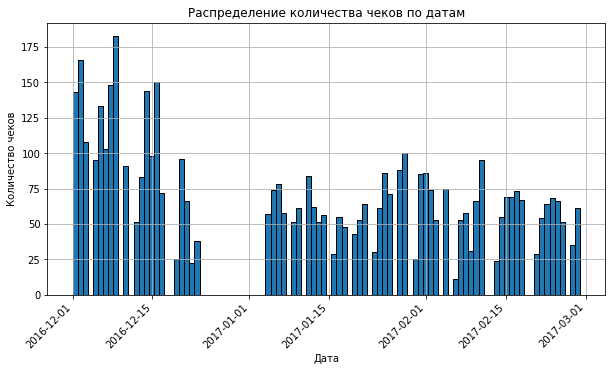

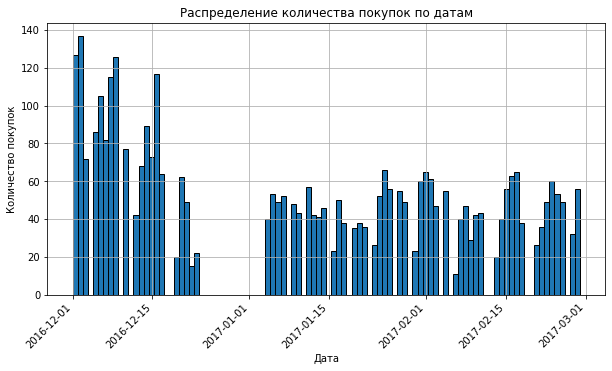

In [22]:
# распределение количества чеков и покупок по датам

hist('date', 'датам' ,'Дата', 'чеков', 'покупок')

На графике выше виден провал в околоновогодние даты. Скорее всего это связано с тем, что несколько дней до и несколько дней после Нового года магазин был закрыт и не принимал / не доставлял товары. 
Количество чеков выше чем, количество покупок, т.к. на эти даты приходятся также и возвраты, и нуевые чеки с возможными подарками.
Более высокие продажи приходятся на декабрь. Это логично, т.к. в магазинах строительных товаров часто продают и новогодние товары (елки, игрушки, мишуру и т.д.) для привлечения большего количества покупателей. Также вполне возможно, что в качестве подарков на Новый год дарят и технику для ремонта (шуруповерты, дрели и т.п.). А с учетом закрытия магазина на новогодние праздники могут в целом повышаться продажи, т.к. люди хотят купить строительные товары, чтобы на новогодних каникулах заняться ремонтом.

In [23]:
# оборот товара (количество и сумма) по месяцам

data_by_month = (
    data
    .groupby('month')
    .agg({'quantity': 'sum', 'revenue': 'sum'})
    .sort_values(by='revenue', ascending=False)
    .reset_index()
)

data_by_month['revenue_percentage'] = round(data_by_month['revenue'] / data_by_month['revenue'].sum() *100, 1)
data_by_month

,month,quantity,revenue,revenue_percentage
0,12,298905,832328.79,38.5
1,1,273389,725516.58,33.5
2,2,249955,606146.24,28.0


В декабре не только большее количество покупок из 3х месяцев, но он лидирует и по выручке - 38.5% от общей выручки приходится на декабрь. А вот в феврале выручка значительно отстает от 2х предыдущих месяцев. Это может быть обусловлено тем, что в декабре-январе обычно проводятся распродажи (и в строительных магазинах тоже), поэтому эти месяцы достаточно прибыльны. Несмотря на то, что есть скидки и цены ниже, выручка получается за счет трафика и конверсии (во время распродаж эти показатели выше).

In [24]:
# продажи и возвраты (в штуках) по месяцам

returns_by_month = (
    data
    .query('quantity > 0')
    .groupby('month')
    .agg({'quantity': 'sum'})
    .merge(
        data
        .query('quantity < 0')
        .groupby('month')
        .agg({'quantity': 'sum'}),
        on='month',
        how='left'
    )
    .reset_index()
)

returns_by_month.columns = ['month', 'sales_qty', 'returns_qty']
returns_by_month['sales_qty_percentage'] = round(returns_by_month['sales_qty'] / returns_by_month['sales_qty'].sum() *100, 1)
returns_by_month['returns_qty_percentage'] = round(returns_by_month['returns_qty'] / returns_by_month['returns_qty'].sum() *100, 1)
returns_by_month

,month,sales_qty,returns_qty,sales_qty_percentage,returns_qty_percentage
0,1,288712,-15323,33.3,33.8
1,2,259111,-9156,29.9,20.2
2,12,319730,-20825,36.9,46.0


В декабре были наибольшие продажи, но и самый высокий процент возвратов, почти половина всех возвратов приходится на декабрь. Видимо, все стараются завершить ремонт до Нового года, и остатки возвращают именно в декабре.

### Анализ данных по магазинам

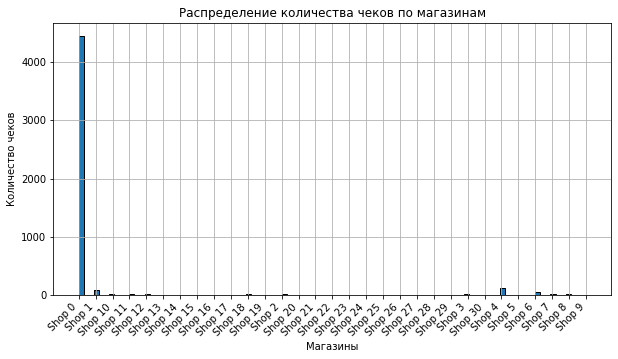

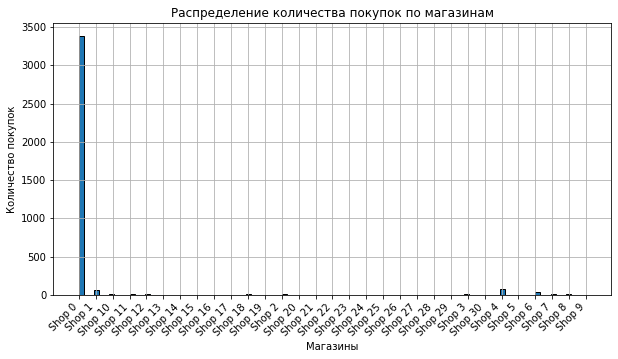

In [25]:
# распределение количества чеков и покупок по магазинам

hist('shop_id', 'магазинам' ,'Магазины', 'чеков', 'покупок')

Наибольшее количество покупок приходится на магазин с id "Shop 0". Не очень понятно, что это: гипермаркет в месте с высокой проходимостью (а остальные магазины - небольшие точки), пункт выдачи товаров, заказанных на маркетплейсе, либо собственный интернет-магазин. В любом случае абсолютное большинство продаж приходится на него.

In [26]:
# оборот товара (количество и сумма) по магазинам

data_by_store = (
    data
    .groupby('shop_id')
    .agg({'quantity': 'sum', 'revenue': 'sum'})
    .sort_values(by='revenue', ascending=False)
    .reset_index()
)

data_by_store['revenue_percentage'] = round(data_by_store['revenue'] / data_by_store['revenue'].sum() *100, 1)
data_by_store

,shop_id,quantity,revenue,revenue_percentage
0,Shop 0,662264,1741395.48,80.5
1,Shop 3,43096,101962.32,4.7
2,Shop 6,18331,55874.46,2.6
3,Shop 4,17937,50534.76,2.3
4,Shop 1,17894,48028.44,2.2
5,Shop 2,14495,39351.85,1.8
6,Shop 14,6893,22150.62,1.0
7,Shop 8,5010,16969.91,0.8
8,Shop 7,4500,11232.99,0.5
9,Shop 19,6986,10246.71,0.5


In [27]:
# проверка магазина "Shop 23"

data.query('shop_id == "Shop 23"')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,month,product_price,revenue
21890,C540155,72802B,-55,2017-01-05 11:31:00,0,Shop 23,0,2017-01-05,1,4.25,-233.75
36752,539500,72802B,53,2016-12-20 11:02:00,0,Shop 23,0,2016-12-20,12,4.25,225.25


80% выручки всей сети приходится на "Shop 0". В одном магазине выручка за 3 месяца отрицательная (сумма возврата выше, чем сумма продажи). И есть 13 магазинов, в которых процент выручки от общей суммы порядка 0.1%, некоторые из этих магазинов, видимо, только открылись, но некоторые работают давно (есть продажи за декабрь в том числе) - на эти магазины нужно обратить внимание и понять, что происходит, почему такая низкая выручка, возможно, дело в расположении (место с низкой проходимостью), или скудный ассортимент (представлены не бестселлеры, которые всегда покупают, а товары, которые не пользуются большим спросом), пересмотреть выкладку товара в торговом зале.

In [28]:
# продажи и возвраты (в штуках) по магазинам

returns_by_store = pd.DataFrame(
    data
    .query('quantity > 0')
    .groupby('shop_id')
    .agg({'quantity': 'sum'})
    .merge(
        data
        .query('quantity < 0')
        .groupby('shop_id')
        .agg({'quantity': 'sum'}),
        on='shop_id',
        how='left'
    )
    .reset_index()
)

returns_by_store.columns = ['shop_id', 'sales_qty', 'returns_qty']
returns_by_store['returns_qty'] = returns_by_store['returns_qty'].fillna(0).apply(lambda x: round(x))

returns_by_store['sales_qty_percentage'] = round(returns_by_store['sales_qty'] / returns_by_store['sales_qty'].sum() *100, 1)
returns_by_store['returns_qty_percentage'] = round(returns_by_store['returns_qty'] / returns_by_store['returns_qty'].sum() *100, 1)
returns_by_store['returns_to_sales'] = round(abs(returns_by_store['returns_qty']) / returns_by_store['sales_qty'] *100, 1)

returns_by_store = returns_by_store.sort_values(by='returns_to_sales', ascending=False).reset_index(drop=True)

returns_by_store

,shop_id,sales_qty,returns_qty,sales_qty_percentage,returns_qty_percentage,returns_to_sales
0,Shop 23,53,-55,0.0,0.1,103.8
1,Shop 21,356,-58,0.0,0.1,16.3
2,Shop 20,364,-49,0.0,0.1,13.5
3,Shop 6,19565,-1234,2.3,2.7,6.3
4,Shop 0,704897,-42633,81.3,94.1,6.0
5,Shop 4,18579,-642,2.1,1.4,3.5
6,Shop 19,7229,-243,0.8,0.5,3.4
7,Shop 11,1366,-36,0.2,0.1,2.6
8,Shop 10,3345,-63,0.4,0.1,1.9
9,Shop 1,18015,-121,2.1,0.3,0.7


Наибольшие продажи приходятся на "Shop 0", но и самый высокий процент возвратов, почти все возвраты, осуществляются также в этом магазине. Т.к. заказы интернет-магазинов часто отгружаются с центрального склада, то логично, что и большинство возвратов, особенно крупные товары, также проходят через этот магазин прямиком на склад.  
При этом в процентном соотношении возвраты/ продажи внутри магазина наибольшие цифры у магазинов "Shop 21", "Shop 20", "Shop 6".

### Общий анализ покупок

In [29]:
# количество покупателей

print('Общее количество уникальных клиентов, включая возвраты и нулевые чеки:',
    data
    .groupby(['customer_id','purchase_id',], as_index=False)
    .agg({'quantity':'sum'}) # группировка по номеру клиента и по номеру чеку
    ['customer_id'].nunique()
)

print('Общее количество уникальных клиентов, не включая возвраты и нулевые чеки:',
    data
    .groupby(['customer_id','purchase_id'], as_index=False)
    .agg({'quantity':'sum'}) # группировка по номеру клиента и по номеру чеку
    .query('quantity > 0')
    ['customer_id'].nunique() 
)

Общее количество уникальных клиентов, включая возвраты и нулевые чеки: 1749
Общее количество уникальных клиентов, не включая возвраты и нулевые чеки: 1671


In [30]:
# количество чеков

print('Общее количество чеков, включая возвраты и нулевые чеки:',
    data
    .groupby('purchase_id', as_index=False)
    .agg({'quantity':'sum'}) # группировка по номеру клиента и по номеру чеку
    ['purchase_id'].count()
)

print('Общее количество покупок, не включая возвраты и нулевые чеки:',
    data
    .groupby('purchase_id', as_index=False)
    .agg({'quantity':'sum'}) # группировка по номеру клиента и по номеру чеку
    .query('quantity > 0')
    ['purchase_id'].count() 
)

Общее количество чеков, включая возвраты и нулевые чеки: 4872
Общее количество покупок, не включая возвраты и нулевые чеки: 3709


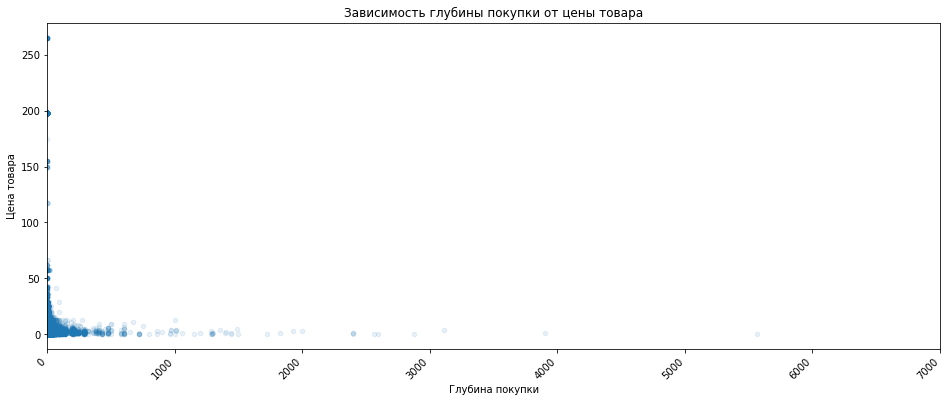

In [31]:
# зависимость глубины покупки от цены товара

data.plot(x='quantity', y='product_price', kind='scatter',alpha=0.1, figsize=(16,6))
plt.xlim([0, 7000])
plt.title('Зависимость глубины покупки от цены товара')
plt.xlabel('Глубина покупки')
plt.ylabel('Цена товара')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Ось x графика ограничили с левой стороны нулем, чтобы на график не попали возвраты, т.к. интересно посмотреть именно продажи.

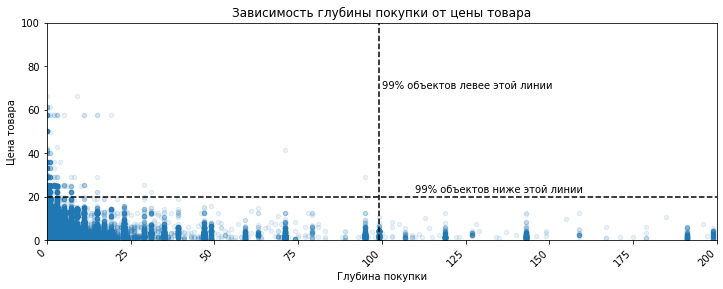

In [32]:
# зависимость глубины покупки от цены товара (ограничение по осям)

data.plot(x='quantity', y='product_price', kind='scatter',alpha=0.1, figsize=(12,4))
plt.xlim([0, 200])
plt.ylim([0,100])
plt.title('Зависимость глубины покупки от цены товара')
plt.xlabel('Глубина покупки')
plt.ylabel('Цена товара')
plt.xticks(rotation=45, horizontalalignment='right')
plt.axhline(np.percentile(data['product_price'], 99), linestyle='--', color='black')
plt.axvline(np.percentile(data['quantity'], 99), linestyle='--', color='black')
plt.text(110,22, '99% объектов ниже этой линии')
plt.text(100,70, '99% объектов левее этой линии')
plt.show()

99% от количество покупок приходится на товары стоимостью до 20 у.е. И 99% от количества товара на 1 код - до 100 штук, хотя и есть товары в чеке с количеством 200шт и более.  
Но т.к. магазин - строительный, то логично, что покупают много мелких товаров. Для более точного анализа нужны наименования товаров или категории, к которым они принадлежат.

In [33]:
# количество чеков и покупок по месяцам

print('Количество чеков по месяцам:')
display(data.groupby('month', as_index=False).agg({'purchase_id': 'nunique'}))

print('\nКоличество покупок по месяцам:')
display(
    data
    .groupby(['month', 'purchase_id'], as_index=False)
    .agg({'quantity':'sum'}) # группировка по номеру клиента и по номеру чеку
    .query('quantity > 0')
    .groupby('month', as_index=False)
    .agg({'purchase_id': 'nunique'})
)

Количество чеков по месяцам:


,month,purchase_id
0,1,1470
1,2,1387
2,12,2015



Количество покупок по месяцам:


,month,purchase_id
0,1,1078
1,2,1083
2,12,1548


Всего за 3 месяца почти 4900 чеков, из них 3709 чеков с покупками, и 41% приходится на декабрь. Что в очередной раз подтверждает, что декабрь более удачный месяц, нежели другие 2.

In [34]:
# товары с нулевым количеством

# группировка данных по чекам
data_grouped = (
    data
    .groupby(['purchase_id', 'date', 'shop_id', 'loyalty_program', 'customer_id'], as_index=False)
    .agg({'quantity': 'sum', 'revenue':'sum'})
)

data_grouped.columns = ['purchase_id', 'date', 'shop_id', 'loyalty_program', 'customer_id', 'quantity', 'revenue']

print('Количество чеков с нулевой суммой:', data_grouped.query('revenue == 0')['purchase_id'].count())
print('Количество клиентов с такими чеками:', data_grouped.query('revenue == 0')['customer_id'].nunique())

Количество чеков с нулевой суммой: 213
Количество клиентов с такими чеками: 42


In [35]:
# возвраты по товарам

returns_by_product = (
    data
    .query('quantity > 0')
    .groupby(['product_id'], as_index=False)
    .agg({'quantity': 'sum'})
    .merge(
        data
        .query('quantity < 0')
        .groupby(['product_id'], as_index=False)
        .agg({'quantity': 'sum'}),
        on='product_id',
        how='left'
    )
)

returns_by_product.columns = ['product_id', 'sales_qty', 'returns_qty']
returns_by_product['returns_qty'] = returns_by_product['returns_qty'].fillna(0)

returns_by_product['sales_qty_percentage'] = round(returns_by_product['sales_qty'] / returns_by_product['sales_qty'].sum() *100, 1)
returns_by_product['returns_qty_percentage'] = round(returns_by_product['returns_qty'] / returns_by_product['returns_qty'].sum() *100, 1)

returns_by_product = returns_by_product.sort_values(by='returns_qty_percentage', ascending=False)
returns_by_product.head(10)

,product_id,sales_qty,returns_qty,sales_qty_percentage,returns_qty_percentage
2138,84347,2300,-9378.0,0.3,21.6
1393,22617,344,-2630.0,0.0,6.1
2218,84611B,1286,-1431.0,0.1,3.3
1150,22351,11,-1401.0,0.0,3.2
1821,35957,681,-1037.0,0.1,2.4
2399,84997C,1025,-742.0,0.1,1.7
229,20956,394,-724.0,0.0,1.7
10,15036,3318,-650.0,0.4,1.5
2504,85123A,10609,-558.0,1.2,1.3
2220,84614A,1,-391.0,0.0,0.9


Есть товары, у которых количество возвращенных штук больше, чем количество купленных. Скорее всего, это возвраты товаров, которые были куплены до анализируемого периода. Лучше всего продажи/возвраты по товарам анализировать за весь год, чтобы была более четкая картина, и чтобы понимать, на какие товары нужно обратить внимание.

### Вывод по разделу

Наиболее прибыльный месяц из 3х (декабрь, январь, февраль) - это декабрь. Это обусловлено и подготовкой к Новому году (покупка новогодних товаров), и распродажей, которая, скорее всего, проводится в сети магазинов и традиционно начинается в декабре. При этом наибольший процент возвратов также приходится на декабрь - видимо, многие стараются завершить ремонт до Нового года, и возвращают остатки в магазины. Но возвраты лучше анализировать за год, 3 месяца - слишком короткий период, т.к. часто ремонты (например, ремонт квартиры, строительство дома) длятся дольше 3х месяцев.  
Наибольшие продажи происходят в магазине "Shop 0" - 80% от всех продаж сети. Скорее всего этот магазин - интернет-магазин. Но есть несколько магазинов, которые требуют пристального внимания, т.к. у них совсем маленькие продажи. Неободимо разобраться в причинах столько низких продаж. Для этого неплохо посмотреть как на сами магазины (местоположение, выкладка, товары и т.д.), так и провести детальный анализ за более длительный период, например, за год, чтобы понять, как эти магазины торговали на протяжении разных сезонов.

## Анализ программы лояльности

### Подсчет средних значений для участников/ не-участников программы лояльности по всем магазинам

In [36]:
# суммарная выручка и количество штук (за исключением возвратных чеков и чеков с нулевым количеством)

upt_atv = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'sum', 'revenue': 'sum'})
)

upt_atv['qty_percentage'] = (upt_atv['quantity'] / upt_atv['quantity'].sum() * 100).round()
upt_atv['revenue_percentage'] = (upt_atv['revenue'] / upt_atv['revenue'].sum() * 100).round()

upt_atv

,loyalty_program,quantity,revenue,qty_percentage,revenue_percentage
0,0,634207,1731237.84,73.0,75.0
1,1,233346,591454.56,27.0,25.0


В разбивке по программам лояльности большую сумму приносят клиенты, которые не участвуют в программе, 75% против 25% у тех, кто участвует. Для того, чтоб более четко определить, нормальная ли это разбивка, нужно посмотреть процентную разбивку между количеством участвующих и неучаствующих в программе клиентами.

In [37]:
# количество клиентов, которые совершили покупки

customers = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'customer_id': 'nunique'})
)

customers['customers_percentage'] = (customers['customer_id'] / customers['customer_id'].sum() * 100).round()

customers

,loyalty_program,customer_id,customers_percentage
0,0,1110,66.0
1,1,561,34.0


Видно, что среди совершивших покупки 34% клиентов являются участниками программы лояльности, но при этом они принесли всего 25% от выручки. То есть клиенты, не участвующие в программе, приносят больше выручки. Необходимо еще раз проверить бонусы программы лояльности, возможно, у участников нет сильного стимула тратить больше.

In [38]:
# средний чек (выручка и глубина чека) за исключением возвратов и чеков с нулевым количеством

avg_upt_atv = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'mean', 'revenue': 'mean'})
    .round()
)

avg_upt_atv

,loyalty_program,quantity,revenue
0,0,245.0,669.0
1,1,208.0,528.0


In [39]:
# среднее количество позиций в чеке за исключением возвратов и чеков с нулевым количеством

(
    data
    .query('quantity > 0')
    .groupby(['purchase_id', 'loyalty_program', ], as_index=False)
    .agg({'quantity': 'count'})
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'mean'})
    .round(2)
)

,loyalty_program,quantity
0,0,20.27
1,1,15.52


По среднему чеку опять же лидируют не-участники программы лояльности, разница в среднем чеке составляет 26%, в средней глубине чека 17%, а в среднем количестве позиций 31%.

In [40]:
# медианный чек (выручка и глубина чека) за исключением возвратов и чеков с нулевым количеством

avg_upt_atv_median = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'median', 'revenue': 'median'})
    .round(2)
)

avg_upt_atv_median

,loyalty_program,quantity,revenue
0,0,116,347.74
1,1,97,296.71


In [41]:
# медианное количество позиций в чеке за исключением возвратов и чеков с нулевым количеством

(
    data
    .query('quantity > 0')
    .groupby(['purchase_id', 'loyalty_program', ], as_index=False)
    .agg({'quantity': 'count'})
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'median'})
    .round(2)
)

,loyalty_program,quantity
0,0,12
1,1,12


Медианные цифры отличаются от средних в меньшую сторону. Т.к. есть чеки в большим количеством товаров (больше 1000 штук), то и средний чек выше. Основная же масса чеков проходит с меньшим количеством. Но опять же тут медианные цифры глубины и выручки выше у тех, кто не участвует в программе лояльности. А вот медианное количество позиций одинаково у участников и не-участников программы лояльности. Т.е. у не-участников программы больше чеков с большим количеством позиций, поэтому и получается, что среднее количество позиций у них выше, а медианное ниже.

In [42]:
# среднее количество чеков на покупателя с имеющимся id за исключением возвратов и чеков с нулевым количеством

(
    data_grouped
    .query('quantity > 0 & customer_id != 0')
    .groupby(['loyalty_program', 'customer_id'], as_index=False)
    .agg({'purchase_id': 'count'}) # группировка по программе лояльности и номеру клиента, подсчет количества чеков на каждого клиента
    .drop(columns = ['customer_id'], axis=1)
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'mean'}) # группировка по программе лояльности, подсчет среднего количества чеков на клиента
    .round(2)
)

,loyalty_program,purchase_id
0,0,1.99
1,1,2.00


Видимого различия в среднем количестве чеков на клиента нет. Для более полной картины можно еще сравнить процент тех, у кого только по 1 чеку за все время. Не берутся в расчет чеки с возвратом и с нулевым количеством (скорее всего, это подарки по промо), т.к. нужно посмотреть именно покупки клиентов, для того, чтобы понимать стимулирует ли программа приобретать что-то дополнительно, т.е. приносить магазинам дополнительный доход.  

In [43]:
# клиенты с нулевыми чеками

(
    data_grouped
    .query('revenue == 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'customer_id': 'nunique'})
)

,loyalty_program,customer_id
0,0,30
1,1,12


In [44]:
# клиенты с нулевыми чеками

(
    data
    .groupby(['loyalty_program', 'purchase_id', 'customer_id'], as_index=False)
    .agg({'revenue':'sum'})
    .query('revenue == 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'customer_id':'nunique'})
)

,loyalty_program,customer_id
0,0,30
1,1,12


Что содержится в чеках с нулевой суммой по текущим данным точно понять невозможно, но, скорее всего, это подарки покупателям. Всего таких нулевых чеков 42, при этом у клиентов без программы лояльности их больше. Возможно, это было отдельное промо для всех покупателей. 

In [45]:
# клиенты без идентификационного номер

(
    data_grouped
    .query('revenue == 0 & customer_id == 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'count'})
)

,loyalty_program,purchase_id
0,0,159


Все клиенты, у которых нет идентификационного номера, не участвуют в программе лояльности.

In [46]:
# распределение участников программы лояльности по магазинам

data_grouped.pivot_table(index='shop_id', columns='loyalty_program', values='purchase_id', aggfunc='count')

loyalty_program,0,1
shop_id,,
Shop 0,3112.0,1337.0
Shop 1,90.0,NaN
Shop 10,15.0,NaN
Shop 11,10.0,NaN
Shop 12,21.0,NaN
Shop 13,4.0,NaN
Shop 14,6.0,NaN
Shop 15,2.0,NaN
Shop 16,4.0,NaN


Из 31 магазина всего в 4х совершают покупки участники программы лояльности. При этом почти все участники за исключением единичных случаев покупают в магазине "Shop 0". Необходимо больше информации о самой программе лояльности, чтобы разобраться, почему так происходит. Возможно, все акции и скидки по программе проходят только в одном магазине. Поэтому имеет смысл проанализировать программу лояльности отдельно по магазину "Shop 0".

### Подсчет средних значений для участников/ не-участников программы лояльности по магазину "Shop 0"

In [47]:
# средний чек (выручка и глубина чека) за исключением возвратов и чеков с нулевым количеством

avg_upt_atv_shop0 = (
    data_grouped
    .query('quantity > 0 & shop_id == "Shop 0"')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'mean', 'revenue': 'mean'})
    .round()
)

avg_upt_atv_shop0

,loyalty_program,quantity,revenue
0,0,211.0,576.0
1,1,203.0,520.0


In [48]:
# среднее количество позиций в чеке за исключением возвратов и чеков с нулевым количеством

(
    data
    .query('quantity > 0 & shop_id == "Shop 0"')
    .groupby(['purchase_id', 'loyalty_program'], as_index=False)
    .agg({'quantity': 'count'})
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'mean'})
    .round(2)
)

,loyalty_program,quantity
0,0,19.96
1,1,15.51


Как и по всем магазинам, по среднему чеку лидируют не-участники программы лояльности, разница в среднем чеке составляет 11%, а в средней глубине чека 4%, а количество позиций в чеке различается на 29%. Но тут разница в цифрах между участниками и не-участниками программы меньше.

In [49]:
# медианный чек (выручка и глубина чека) за исключением возвратов и чеков с нулевым количеством

avg_upt_atv__shop0_median = (
    data_grouped
    .query('quantity > 0 & shop_id == "Shop 0"')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'median', 'revenue': 'median'})
    .round()
)

avg_upt_atv__shop0_median

,loyalty_program,quantity,revenue
0,0,110.0,327.0
1,1,96.0,296.0


In [50]:
# медианное количество позиций в чеке за исключением возвратов и чеков с нулевым количеством

(
    data
    .query('quantity > 0 & shop_id == "Shop 0"')
    .groupby(['purchase_id', 'loyalty_program'], as_index=False)
    .agg({'quantity': 'count'})
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'median'})
    .round()
)

,loyalty_program,quantity
0,0,12
1,1,12


Медианные цифры примерно совпадают с тем, что получили по всем магазинам. Тут они также сильно меньше средних.

In [51]:
# среднее количество чеков на покупателя с имеющимся id за исключением возвратов и чеков с нулевым количеством

avg_qty_checks_shop0 = (
    data_grouped
    .query('quantity > 0 & customer_id != 0  & shop_id == "Shop 0"')
    .groupby(['loyalty_program', 'customer_id'], as_index=False)
    .agg({'purchase_id': 'count'}) # группировка по программе лояльности и номеру клиента, подсчет количества чеков на каждого клиента
    .drop(columns = ['customer_id'], axis=1)
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'mean'}) # группировка по программе лояльности, подсчет среднего количества чеков на клиента
    .round()
)

avg_qty_checks_shop0

,loyalty_program,purchase_id
0,0,2.0
1,1,2.0


Как и по всем магазинам, видимого различия в среднем количестве чеков на клиента нет.

### Определение чеков только с одним товаром в чеке

In [52]:
# общее количество чеков

checks = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'count'})
)

In [53]:
checks_1_item = (
    data
    .query('quantity > 0')
    .groupby(['loyalty_program', 'purchase_id'], as_index=False)
    .agg({'quantity': 'count'})
    .query('quantity == 1')
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'count'})
)

In [54]:
# количество чеков с одним товаром к общему количеству чеков

checks_comparison = checks.merge(checks_1_item, on='loyalty_program', how='left')
checks_comparison.columns = ['loyalty_program', 'total_qty_checks', 'checks_with_1_item']

checks_comparison['check_1_item_to_total'] = round(
    checks_comparison['checks_with_1_item'] / 
    checks_comparison['total_qty_checks'] * 100
)

checks_comparison

,loyalty_program,total_qty_checks,checks_with_1_item,check_1_item_to_total
0,0,2589,302,12.0
1,1,1120,87,8.0


У тех, кто не участвует в программе лояльности, больше чеков только с одним товаром - 12% от общего количества чеков в этой группе. А те, кто участвует в программе, приобретают обычно больше одного товара.

In [55]:
# количество возвратов

returns_by_loyalty = (
    data_grouped
    .query('quantity > 0')
    .groupby('loyalty_program',as_index=False)
    .agg({'quantity': 'sum',})
    .merge(
        data_grouped
        .query('quantity < 0')
        .groupby('loyalty_program')
        .agg({'quantity': 'sum',}),
        on='loyalty_program',
        how='left'
    )
)

returns_by_loyalty.columns = ['loyalty_program', 'sales', 'returns']
returns_by_loyalty['sales_percentage'] = round(returns_by_loyalty['sales'] / returns_by_loyalty['sales'].sum() * 100, 1)
returns_by_loyalty['returns_percentage'] = round(returns_by_loyalty['returns'] / returns_by_loyalty['returns'].sum() * 100, 1)
returns_by_loyalty['returns_to_sales'] = round(abs(returns_by_loyalty['returns']) / returns_by_loyalty['sales'] * 100, 1)

returns_by_loyalty

,loyalty_program,sales,returns,sales_percentage,returns_percentage,returns_to_sales
0,0,634207,-40651,73.1,89.7,6.4
1,1,233346,-4653,26.9,10.3,2.0


In [56]:
# количество возвратных чеков

total_checks = (
    data_grouped
    .query('quantity != 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'count'})
)

return_checks = (
    data_grouped
    .query('quantity < 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'purchase_id': 'count'})
)

returns = total_checks.merge(return_checks, on='loyalty_program', how='left')

returns.columns = ['loyalty_program', 'total_qty_checks', 'qty_return_checks']
returns['percent_returns'] = (returns['qty_return_checks'] / returns['total_qty_checks'] * 100).round()
returns

,loyalty_program,total_qty_checks,qty_return_checks,percent_returns
0,0,3379,790,23.0
1,1,1331,211,16.0


У участников программы лояльности меньше возвратов: 16% возвратных чеков против 22% у не-участников и всего 2% отношение возвратов к продажам.

### Определение клиентов только с одной покупкой за все время

In [57]:
# общее количество клиентов с идентификацонным номером

customer_purchases = (
    data_grouped
    .query('quantity > 0 & customer_id != 0')
    .groupby('loyalty_program', as_index=False)
    .agg({'customer_id': 'nunique'})
)

customer_purchases

,loyalty_program,customer_id
0,0,1109
1,1,561


In [58]:
# количество клиентов только с одной покупкой за все время

customers_1_purchase = (
    data_grouped
    .query('quantity > 0  & customer_id != 0')
    .groupby(['loyalty_program', 'customer_id'], as_index=False)
    .agg({'purchase_id': 'count'}) # группировка по программе лояльности, подсчет количества чеков у клиента
    .query('purchase_id == 1')
    .groupby('loyalty_program', as_index=False)
    .agg({'customer_id': 'nunique'}) # подсчет количества клиентов с одной покупкой
)

customers_1_purchase

,loyalty_program,customer_id
0,0,697
1,1,319


In [59]:
# количество клиентов с одной покупкой к общему количеству чеков

customers_comparison = customer_purchases.merge(customers_1_purchase, on='loyalty_program', how='left')
customers_comparison.columns = ['loyalty_program', 'total_qty_checks', 'checks_with_1_item']

customers_comparison['check_1_item_to_total'] = round(
    customers_comparison['checks_with_1_item'] / 
    customers_comparison['total_qty_checks'] * 100
)

customers_comparison

,loyalty_program,total_qty_checks,checks_with_1_item,check_1_item_to_total
0,0,1109,697,63.0
1,1,561,319,57.0


Те, кто участвует в программе лояльности, чаще совершают повторные покупки - 43% покупателей возвращаются. Среди тех, кто не принимает участия в программе лояльности таких всего 37%.

### Вывод по разделу

В разбивке по программам лояльности большую сумму приносят клиенты, которые не участвуют в программе. При чем 66% покупателей не являются участниками программы, и они приносят 75% выручки. Не-участники также лидируют и по показателям средних и медианных чека и глубины. А вот по количеству позиций немного другая картина: среднее количество позиций выше у не-участников программы лояльности, но медианный показатель у не-участников ниже. Т.е. у не-участников программы больше чеков с большим количеством позиций, поэтому среднее количество позиций у них выше, а медианное ниже.  
Из 31 магазина всего в 4х совершают покупки участники программы лояльности. При этом почти все участники за исключением единичных случаев покупают в магазине "Shop 0".  Тут также, как и по всем магазинам показатели средних и медианных чека и глубины выше у не-участников программы.    
У участников программы меньший процент возвратов, всего 2%. Также те, кто участвует в программе лояльности, чаще совершают повторные покупки.  
Чтобы разобраться в причинах того, почему участники программы лояльности совершают покупки только в 4х магазинах, необходимо больше информации о самой программе лояльности. Возможно, все акции и скидки по программе проходят только в одном магазине.

### Кластеризация клиентов

In [60]:
# данные для кластеризации (только чеки с покупками, без нулевых и возвратных чеков)

x = (
    data_grouped
    .query('quantity > 0')
    .drop(columns=['purchase_id', 'date', 'shop_id', 'customer_id'], axis=1)
)
x.head()

,loyalty_program,quantity,revenue
0,1,33,186.50
1,1,10,19.80
2,0,71,285.49
3,0,11,96.09
4,0,2,13.20


In [61]:
# стандартизация данных

scaler = StandardScaler()
x_st = scaler.fit_transform(x)

In [62]:
# матрица расстояний на стандартизованной матрице признаков

linked = linkage(x_st, method='ward')

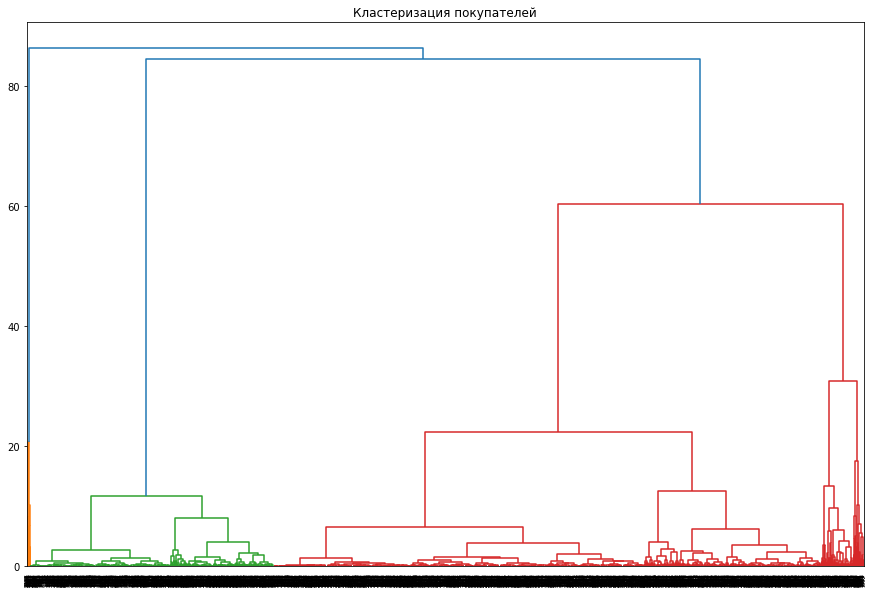

In [63]:
# дендрограмма

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация покупателей')
plt.show()

In [64]:
# обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров покупателей

km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(x_st)
x['cluster'] = labels

In [65]:
# количество клиентов в кластере

display(x.groupby(['cluster'])['quantity'].count())

cluster
0    2475
1     126
2    1092
3      16
Name: quantity, dtype: int64

In [66]:
# средние значения признаков для кластеров

round(x.groupby(['cluster']).mean().T)

cluster,0,1,2,3
loyalty_program,0.0,0.0,1.0,0.0
quantity,167.0,1627.0,148.0,5556.0
revenue,456.0,3994.0,392.0,16381.0


Дендрограмма разделила пользователей на 2 кластера (с учетом только программы лояльности, глубины и суммы чека), один из которых сильно больше другого. Считаю, что логичнее было бы разделить на 4 кластера и посмотреть на кластеры с большими/маленькими покупками. В итоге получили, что имеется только 1 кластер с участниками программы лояльности, и тут самая низкая средняя глубина и сумма чека. Остальные 3 кластера - те, кто в программе лояльности не участвуют.  
Количество клиентов в кластерах сильно разнится, например, в кластере 3 только 16 клиентов с самыми большими чеками.

## Проверка статистических гипотез

### Гипотеза о различии средних значений покупки, глубины чека и частоты покупок между теми, кто участвует в программе лояльности, и теми, кто не участвует для всех магазинов

**Нулевая гипотеза** - статическая значимость не значительная, различий в средних значениях покупки, глубины чека и частоты покупок нет.  
**Альтернативная гипотеза** - статическая значимость значительная, есть различия в средних значениях.  
Порог статической значимости 0.05.  
Считаем только по тем клиентам, у которых есть покупки, не берем в расчет возвраты и нулевые чеки, т.к. нужно понять работает или нет программа лояльности, стимулирует ли она клиентов покупать больше.

In [67]:
# функция для проверки гипотез по выручке и глубине чека

def hypothesis(argument, name, name2):
    data_0 = pd.Series(data_grouped.query('quantity > 0 & loyalty_program == 0')[argument])
    data_1 = pd.Series(data_grouped.query('quantity > 0 & loyalty_program == 1')[argument])
    
    print('Средн{} для не-участников программы лояльности:'.format(name), data_0.mean().round(2))
    print('Средн{} для участников программы лояльности:'.format(name), data_1.mean().round(2))
    
    alpha = 0.05
    results_revenue = st.ttest_ind(data_0, data_1, equal_var=True)
    
    print('\nP-value:{}'.format(results_revenue.pvalue))
    
    if results_revenue.pvalue < alpha:
        print('Разница средн{} между участниками и не-участниками программы лояльности статистически значима'.format(name2))
    else:
        print('Разница средн{} между участниками и не-участниками программы лояльности статистически не значима'.format(name2))
    
    print(
    'Разница средн{} между участниками и не-участниками программы лояльности:'.format(name2), 
    '{0:.3f}'.format(data_0.mean() / data_1.mean() - 1)
    )

In [68]:
# считаем статистическое различие в средней выручке

hypothesis('revenue', 'яя выручка', 'ей выручки')

Средняя выручка для не-участников программы лояльности: 668.69
Средняя выручка для участников программы лояльности: 528.08

P-value:0.004747132615729018
Разница средней выручки между участниками и не-участниками программы лояльности статистически значима
Разница средней выручки между участниками и не-участниками программы лояльности: 0.266


Разница в средней выручке между участниками и не-участниками программы лояльности составляет 27%, и у не-участников программы средняя выручка выше. Различие является существенным.

In [69]:
# считаем статистическое различие в средней глубине чека

hypothesis('quantity', 'яя глубина чека', 'ей глубины чека')

Средняя глубина чека для не-участников программы лояльности: 244.96
Средняя глубина чека для участников программы лояльности: 208.34

P-value:0.045470252947869515
Разница средней глубины чека между участниками и не-участниками программы лояльности статистически значима
Разница средней глубины чека между участниками и не-участниками программы лояльности: 0.176


Разница в средней глубине чека между участниками и не-участниками программы лояльности составляет 18%, и у не-участников программы средняя глубина чека выше. Различие является существенным.

In [70]:
# считаем статистическое различие в среднем количестве позиций в чеке

no_of_sku_0 = pd.Series(
        data
       .query('quantity > 0 & loyalty_program == 0')
       .groupby('purchase_id' , as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

no_of_sku_1 = pd.Series(
        data
       .query('quantity > 0 & loyalty_program == 1')
       .groupby('purchase_id', as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

print('Среднее количество позиций для не-участников программы лояльности:', no_of_sku_0.mean().round(2))
print('Среднее количество позиций для участников программы лояльности:', no_of_sku_1.mean().round(2))
    
alpha = 0.05
results_revenue = st.ttest_ind(no_of_sku_0, no_of_sku_1, equal_var=True)
    
print('\nP-value:{}'.format(results_revenue.pvalue))
    
if results_revenue.pvalue < alpha:
    print('Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически значима')
else:
    print('Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически не значима')
    
print(
    'Разница среднего количества позиций между участниками и не-участниками программы лояльности:', 
    '{0:.3f}'.format(no_of_sku_0.mean() / no_of_sku_1.mean() - 1)
)

Среднее количество позиций для не-участников программы лояльности: 20.27
Среднее количество позиций для участников программы лояльности: 15.52

P-value:2.6302648557690815e-06
Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически значима
Разница среднего количества позиций между участниками и не-участниками программы лояльности: 0.306


Разница в среднем количестве позиций в чеке между участниками и не-участниками программы лояльности составляет 31%, и у не-участников программы количество позиций больше. Различие является существенным.

По итогам проверки нулевая гипотеза о том, что нет статистической разницы в средних показателей, не подтвердилась.

### Гипотеза о различии средних значений покупки, глубины чека и частоты покупок между теми, кто участвует в программе лояльности, и теми, кто не участвует для магазина "Shop 0"

**Нулевая гипотеза** - статическая значимость не значительная, различий в средних значениях покупки, глубины чека и частоты покупок нет.  
**Альтернативная гипотеза** - статическая значимость значительная, есть различия в средних значениях.  
Порог статической значимости 0.05.  
Считаем только по тем клиентам, у которых есть покупки, не берем в расчет возвраты и нулевые чеки, т.к. нужно понять работает или нет программа лояльности, стимулирует ли она клиентов покупать больше.

In [71]:
# функция для проверки гипотез для магазина "Shop 0"

def hypothesis_shop0(argument, name, name2):
    data_0 = pd.Series(data_grouped.query('quantity > 0 & loyalty_program == 0 & shop_id == "Shop 0"')[argument])
    data_1 = pd.Series(data_grouped.query('quantity > 0 & loyalty_program == 1 & shop_id == "Shop 0"')[argument])
    
    print('Средн{} для не-участников программы лояльности:'.format(name), data_0.mean().round(2))
    print('Средн{} для участников программы лояльности:'.format(name), data_1.mean().round(2))
    
    alpha = 0.05
    results_revenue = st.ttest_ind(data_0, data_1, equal_var=True)
    
    print('\nP-value:{}'.format(results_revenue.pvalue))
    
    if results_revenue.pvalue < alpha:
        print('Разница средн{} между участниками и не-участниками программы лояльности статистически значима'.format(name2))
    else:
        print('Разница средн{} между участниками и не-участниками программы лояльности статистически не значима'.format(name2))
    
    print(
    'Разница средн{} между участниками и не-участниками программы лояльности:'.format(name2), 
    '{0:.3f}'.format(data_0.mean() / data_1.mean() - 1)
    )

In [72]:
# считаем статистическое различие в средней выручке

hypothesis_shop0('revenue', 'яя выручка', 'ей выручки')

Средняя выручка для не-участников программы лояльности: 576.44
Средняя выручка для участников программы лояльности: 520.25

P-value:0.16182839227493992
Разница средней выручки между участниками и не-участниками программы лояльности статистически не значима
Разница средней выручки между участниками и не-участниками программы лояльности: 0.108


Разница в средней выручке между участниками и не-участниками программы лояльности составляет 11%, и у не-участников программы средняя выручка выше. Но при этом различие является не существенным и статистически незначимым.

In [73]:
# считаем статистическое различие в средней глубине чека

hypothesis_shop0('quantity', 'яя глубина чека', 'ей глубины чека')

Средняя глубина чека для не-участников программы лояльности: 211.1
Средняя глубина чека для участников программы лояльности: 202.98

P-value:0.5762257247916021
Разница средней глубины чека между участниками и не-участниками программы лояльности статистически не значима
Разница средней глубины чека между участниками и не-участниками программы лояльности: 0.040


Разница в средней глубине чека между участниками и не-участниками программы лояльности составляет 4%, и у не-участников программы средняя глубина чека выше. Но при этом различие является не существенным и статистически незначимым.

In [74]:
# считаем статистическое различие в среднем количестве позиций в чеке

no_of_sku_0_shop0 = pd.Series(
        data
       .query('quantity > 0 & loyalty_program == 0 & shop_id == "Shop 0"')
       .groupby('purchase_id' , as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

no_of_sku_1_shop0  = pd.Series(
        data
       .query('quantity > 0 & loyalty_program == 1 & shop_id == "Shop 0"')
       .groupby('purchase_id', as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

print('Среднее количество позиций для не-участников программы лояльности:', no_of_sku_0_shop0.mean().round(2))
print('Среднее количество позиций для участников программы лояльности:', no_of_sku_1_shop0.mean().round(2))
    
alpha = 0.05
results_revenue = st.ttest_ind(no_of_sku_0_shop0, no_of_sku_1_shop0, equal_var=True)
    
print('\nP-value:{}'.format(results_revenue.pvalue))
    
if results_revenue.pvalue < alpha:
    print('Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически значима')
else:
    print('Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически не значима')
    
print(
    'Разница среднего количества позиций между участниками и не-участниками программы лояльности:', 
    '{0:.3f}'.format(no_of_sku_0_shop0.mean() / no_of_sku_1_shop0.mean() - 1)
)

Среднее количество позиций для не-участников программы лояльности: 19.96
Среднее количество позиций для участников программы лояльности: 15.51

P-value:2.4324917392971207e-05
Разница среднего количества позиций между участниками и не-участниками программы лояльности статистически значима
Разница среднего количества позиций между участниками и не-участниками программы лояльности: 0.287


Разница в среднем количестве позиций в чеке между участниками и не-участниками программы лояльности составляет 29%, и у не-участников программы количество позиций больше. Различие является существенным.

По итогам проверки нулевая гипотеза о том, что нет статистической разницы в средних показателей для магазина "Shop 0", подтвердилась для выручки и глубины чека, но не подтвердилась для среднего количества товаров в чеке.

## Общий вывод

### Цель проекта:

Провести анализ программы лояльности магазина, чтобы понять, приносит ли программа дополнительный доход, стимулирует ли она клиентов покупать больше товаров в магазинах, и дать рекомендации по дальнейшему развитию программы.


### Входные данные:
Файл с данными клиентов за предыдущий до проверки факта оттока месяц, информацией на основе журнала посещений, покупок и информацией о текущем статусе абонемента клиента.

### Действия по проекту

Была проведена предобработка данных:
 - изменены названия столбцов,
 - изменены типы данных в столбцах "customer_id", "purchase_date", "loyaltu_program",
 - отсутствующие id клиентов в столбце "customer_id" заменены на 0б
 - удалены строки-дубликаты из датасета `retail`,
 - удалены строки с кодами продукта "AMAZONFEE" и "BANK CHARGES", а также строки с гигантским заказом/возвратом из датасета `retail`,
 - датасет `product` сгруппирован по коду товара и вычислена медианная цена.

Был проведен исследовательский анализ данных (EDA):
 - добавлены столбцы "date", "month" - дата и месяц покупки, "revenue" - общая стоимость кода товара,
 - определен диапазон дат в датасете,
 - постороены гистограммы распределения покупок по датам и по магазинам,
 - посчитан оборот товара (количество и сумма) по месяцам и по магазинам,
 - посчитаны продажи и возвраты по месяцам и по магазинам,
 - определено количество покупателей и количество чеков,
 - построен график зависимости глубины покупки от стоимоти товара,
 - определены товары с нулевым количеством,
 - посчитаны проценты продажи и возвратов на код товара.
 
Была проведен анализ программы лояльности с разбивкой на учатники/не-участники программы:
 - определена суммарная выручка (количество и деньги),
 - определено количество клиентов,
 - посчитаны средние и медианные значения суммы чека, глубины покупки, количества позиций в чеке,
 - посчитано среднее количество покупок на клиента,
 - определено количество чеков с одним товаром,
 - определено количество возвратов,
 - определено количество клиентов только с одной покупкой,
 - проведена кластеризация клиентов.
  
Были проверены гипотезы:
- гипотеза о различии средних значений покупки, глубины чека и количества позиций в чеке между теми, кто участвует в программе лояльности, и теми, кто не участвует для всех магазинов,
- гипотеза о различии средних значений покупки, глубины чека и количества позиций в чеке между теми, кто участвует в программе лояльности, и теми, кто не участвует для магазина "Shop 0".

### Вывод

Исходя из исследования, видно, что программа лояльности работает не так, как хотелось бы. Основные показатели у участников программы лояльности даже ниже, чем у тех, кто не участвовал в программе:
 - средняя сумма чека на 27% для всех магазинов и на 11% для магазина "Shop 0",
 - средняя глубина чека на 18% для всех магазинов и на 4% для магазина "Shop 0",
 - количество позиций в чеке на 31% для всех магазинов и на 29% для магазина "Shop 0",
 - одинаково среднее количество покупок на покупателя - 2 покупки. 
 
Это означает, что программа лояльности не стимулирует покупателей приобретать больше товаров. Возможно, программа лояльности просто дает небольшую прямую скидку на товары  (например 3-5%), которая не является критической в принятии решения о дополнительной покупке.  
За 3 месяца 34% клиентов, совершивших покупки, были участниками программы лояльности, при этом они принесли всего 25% от выручки. У клиентов-участников программы в меньшем количестве случаев только 1 товар в чеке - 8% чеков с одним товаром от общего количества у участников программы против 12% у не-участников. Также у клиентов-участников меньший процент возвратов - на эту группу клиентов приходится всего 10% от всего возвращаемого количества товаров и всего 2% в соотношении возвраты/продажи, то есть участники программы более осознанно походят к покупке. Но для более четкой картины и для более верных выводов по возвратам необходимо смотреть более длительный период, т.к. вполне вероятно, что люди заканчивают ремонт в околоновогодний период, и в этот период в принципе большие возвраты.  
По ходу исследования было сделано достаточно выводов о программе лояльности, поэтому необходимо сосредоточиться на дальнейшем ее развитии и рассмотреть рекомендации о том, как можно улучшить программу, чтобы привлечь к ней больше клиентов и получить больший доход.

### Рекомендации

Так как нет четкой информации о том, как работает программа лояльности в магазинах, то в следующих пунктах будет выстроена программа лояльности с нуля. Какие-то из этих пунктов уже могут использоваться, а другие можно взять на заметку.

1. Убрать ежемесячную оплату программы, вместо этого либо просто бесплатно выдавать отдельные карты участника программы, либо ввести возможность их покупки за единоразовую выплату 100-200 у.е.
2. Ввести накопительную систему бонусов - бонусы возвращаются на карту в размере 5-10% от суммы покупки либо 1 бонус на каждые 100 у.е покупки, а при возврате списываются в эквивалентном размере. Бонусы можно копить, а можно ими оплачивать часть покупки, например, 20-30% от суммы чека.
3. Первоначальная скидка для всех участников программы 3-5%, далее скидка увеличивается по мере накопления бонусов после достижения определенных порогов (для того, чтобы определить пороги бонусов нужно провести дополнительное исследование за годовой период). Скидка по программе лояльности не суммируется со скидками по акциям, если нет иных условий, в одном чеке можно применить либо скидку по программе, либо оплату бонусами.
4. При достижении бонусного порога участник программы может выбрать подарок либо на определенную сумму, либо из заранее составленного списка товаров, которые предлагаются в качестве подарков.
5. Для участников программы проводятся отдельные акции, а также распродажа начинается на 1-2 дня раньше, чем для тех, кто не участвует.
6. Для участников программы проводятся кросс-акции с магазинами других брендов (например, с магазинами техники).
